<a href="https://colab.research.google.com/github/Ennydaniel/Ptzza-Place-Sales-Analysis/blob/main/ACHEGBANI_ENOCH_DANIEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pizza Place Sales — Analysis
Answering the task questions step-by-step.


# Setup the files, load the files and detect columns, merge the files together.

In [ ]:
#To import libraries, to load, to detect minimal columns, to clean, and lastly to merge.
import pandas as pd, numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
%matplotlib inline

orders = pd.read_csv(r'/content/orders.csv')
od = pd.read_csv(r'/content/order_details.csv')
pizzas = pd.read_csv(r'/content/pizzas.csv')
pt = pd.read_csv(r'/content/pizza_types.csv', encoding='latin1')

def pick(df, keywords):
    for k in keywords:
        for c in df.columns:
            if k in c.lower():
                return c
    return None

o_id = pick(orders, ['order_id','orderid','id','order'])
o_date = pick(orders, ['order_date','date','time','created'])
od_oid = pick(od, ['order_id','orderid','order'])
od_pid = pick(od, ['pizza_id','pizza','product','item'])
od_qty = pick(od, ['qty','quantity','count','amount'])
od_price = pick(od, ['unit_price','unitprice','price','price_each','item_price'])
od_line = pick(od, ['line_total','total','subtotal','extended'])

p_pid = pick(pizzas, ['pizza_id','pizzaid','id','product'])
p_name = pick(pizzas, ['pizza_name','name','title'])
p_type = pick(pizzas, ['pizza_type_id','type_id','type','category','category_id'])
p_menu = pick(pizzas, ['menu_price','price','cost'])

pt_tid = pick(pt, ['pizza_type_id','type_id','id'])
pt_name = pick(pt, ['pizza_type_name','type_name','name','category'])

#if detection fails show columns to set exact names.
if None in (o_id,o_date,od_oid,od_pid,od_qty):
    print("orders.columns:", list(orders.columns))
    print("order_details.columns:", list(od.columns))
    print("pizzas.columns:", list(pizzas.columns))
    print("pizza_types.columns:", list(pt.columns))https://accounts.google.com/SignOutOptions?hl=en&continue=https://colab.research.google.com/drive/14VCfSzCNRR2rRbd8G5egsqpynhxAJPTf&ec=GBRAqQM
    raise SystemExit("Edit detection or update files names and rerun this cell.")

#Rename to standard names.
orders = orders.rename(columns={o_id:'order_id', o_date:'order_date'})
od = od.rename(columns={od_oid:'order_id', od_pid:'pizza_id', od_qty:'quantity', od_price:'unit_price', od_line:'line_total'})
pizzas = pizzas.rename(columns={p_pid:'pizza_id', p_name:'pizza_name', p_type:'pizza_type_id', p_menu:'menu_price'})
pt = pt.rename(columns={pt_tid:'pizza_type_id', pt_name:'pizza_type_name'})

#Types and compute the line_total if missing.
orders['order_date'] = pd.to_datetime(orders['order_date'], errors='coerce')
od['quantity'] = pd.to_numeric(od.get('quantity',0), errors='coerce').fillna(0).astype(int)
od['unit_price'] = pd.to_numeric(od.get('unit_price'), errors='coerce')
od['line_total'] = pd.to_numeric(od.get('line_total'), errors='coerce')
mask = od['line_total'].isna()
od.loc[mask, 'line_total'] = od.loc[mask, 'quantity'] * od.loc[mask, 'unit_price'].fillna(0)

#To ensure the id columns are strings for safe merges
for df, cols in [(orders, ['order_id']), (od, ['order_id','pizza_id']), (pizzas, ['pizza_id','pizza_type_id']), (pt, ['pizza_type_id'])]:
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str)

#Merging into full single table.
full = (od
        .merge(pizzas.drop_duplicates('pizza_id'), on='pizza_id', how='left')
        .merge(pt.drop_duplicates('pizza_type_id'), on='pizza_type_id', how='left')
        .merge(orders[['order_id','order_date']].drop_duplicates('order_id'), on='order_id', how='left'))

display(Markdown(f"### Merge complete: `{len(full)}` detail rows; orders: {orders['order_id'].nunique()} distinct"))


### Merge complete: `48620` detail rows; orders: 21350 distinct

# A quick diagnostics and a summary of missing data!

In [ ]:
# Diagnostics
diag = {
    'orders_rows': len(orders),
    'order_details_rows': len(od),
    'pizzas_rows': len(pizzas),
    'pizza_types_rows': len(pt),
    'merged_rows': len(full),
    'distinct_orders': orders['order_id'].nunique(),
    'distinct_pizzas_menu': pizzas['pizza_id'].nunique(),
    'distinct_types': pt['pizza_type_id'].nunique() if 'pizza_type_id' in pt.columns else 'N/A',
    'date_range': (orders['order_date'].min(), orders['order_date'].max())
}
missing = full.isna().sum().sort_values(ascending=False)
dups = od.duplicated().sum()

display(Markdown("## Quick diagnostics"))
display(Markdown(f"- Rows: orders={diag['orders_rows']}, order_details={diag['order_details_rows']}, pizzas={diag['pizzas_rows']}, pizza_types={diag['pizza_types_rows']}"))
display(Markdown(f"- Merged detail rows: {diag['merged_rows']} | Distinct orders: {diag['distinct_orders']} | pizzas on menu: {diag['distinct_pizzas_menu']}"))
display(Markdown(f"- Date range in `orders.order_date`: {diag['date_range'][0]}  →  {diag['date_range'][1]}"))
display(Markdown("### Missing values (merged table) — top columns"))
print(missing.head(10))
display(Markdown(f"- Duplicate rows in order_details: {dups}"))


## Quick diagnostics

- Rows: orders=21350, order_details=48620, pizzas=96, pizza_types=32

- Merged detail rows: 48620 | Distinct orders: 21350 | pizzas on menu: 96

- Date range in `orders.order_date`: 2015-01-01 00:00:00  →  2015-12-31 00:00:00

### Missing values (merged table) — top columns

unit_price          48620
order_details_id        0
order_id                0
pizza_id                0
quantity                0
line_total              0
pizza_type_id           0
size                    0
menu_price              0
pizza_type_name         0
dtype: int64


- Duplicate rows in order_details: 0

In [ ]:
# Show first 10 rows
full.head(10)


,order_details_id,order_id,pizza_id,quantity,unit_price,line_total,pizza_type_id,size,menu_price,pizza_type_name,category,ingredients,order_date
0,1,1,hawaiian_m,1,NaN,0.0,hawaiian,M,13.25,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",2015-01-01
1,2,2,classic_dlx_m,1,NaN,0.0,classic_dlx,M,16.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",2015-01-01
2,3,2,five_cheese_l,1,NaN,0.0,five_cheese,L,18.50,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",2015-01-01
3,4,2,ital_supr_l,1,NaN,0.0,ital_supr,L,20.75,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01
4,5,2,mexicana_m,1,NaN,0.0,mexicana,M,16.00,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",2015-01-01
5,6,2,thai_ckn_l,1,NaN,0.0,thai_ckn,L,20.75,The Thai Chicken Pizza,Chicken,"Chicken, Pineapple, Tomatoes, Red Peppers, Tha...",2015-01-01
6,7,3,ital_supr_m,1,NaN,0.0,ital_supr,M,16.50,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01
7,8,3,prsc_argla_l,1,NaN,0.0,prsc_argla,L,20.75,The Prosciutto and Arugula Pizza,Supreme,"Prosciutto di San Daniele, Arugula, Mozzarella...",2015-01-01
8,9,4,ital_supr_m,1,NaN,0.0,ital_supr,M,16.50,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01
9,10,5,ital_supr_m,1,NaN,0.0,ital_supr,M,16.50,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01


In [ ]:
full.fillna(0.00, inplace=True)

full

,order_details_id,order_id,pizza_id,quantity,unit_price,line_total,pizza_type_id,size,menu_price,pizza_type_name,category,ingredients,order_date
0,1,1,hawaiian_m,1,0.0,0.0,hawaiian,M,13.25,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",2015-01-01
1,2,2,classic_dlx_m,1,0.0,0.0,classic_dlx,M,16.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",2015-01-01
2,3,2,five_cheese_l,1,0.0,0.0,five_cheese,L,18.50,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",2015-01-01
3,4,2,ital_supr_l,1,0.0,0.0,ital_supr,L,20.75,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01
4,5,2,mexicana_m,1,0.0,0.0,mexicana,M,16.00,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,0.0,0.0,ckn_alfredo,M,16.75,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",2015-12-31
48616,48617,21348,four_cheese_l,1,0.0,0.0,four_cheese,L,17.95,The Four Cheese Pizza,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",2015-12-31
48617,48618,21348,napolitana_s,1,0.0,0.0,napolitana,S,12.00,The Napolitana Pizza,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",2015-12-31
48618,48619,21349,mexicana_l,1,0.0,0.0,mexicana,L,20.25,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",2015-12-31


In [ ]:
# Show shape (rows, columns)
full.shape


(48620, 13)

In [ ]:
# Show column names
full.columns


Index(['order_details_id', 'order_id', 'pizza_id', 'quantity', 'unit_price', 'line_total', 'pizza_type_id', 'size', 'menu_price', 'pizza_type_name', 'category', 'ingredients', 'order_date'], dtype='object')

In [ ]:
# General info
full.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_details_id  48620 non-null  int64         
 1   order_id          48620 non-null  object        
 2   pizza_id          48620 non-null  object        
 3   quantity          48620 non-null  int64         
 4   unit_price        48620 non-null  float64       
 5   line_total        48620 non-null  float64       
 6   pizza_type_id     48620 non-null  object        
 7   size              48620 non-null  object        
 8   menu_price        48620 non-null  float64       
 9   pizza_type_name   48620 non-null  object        
 10  category          48620 non-null  object        
 11  ingredients       48620 non-null  object        
 12  order_date        48620 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 4.8+ MB


In [ ]:
# Quick summary statistics (numeric columns)
full.describe()



,order_details_id,quantity,unit_price,line_total,menu_price,order_date
count,48620.000000,48620.000000,48620.0,48620.0,48620.000000,48620
mean,24310.500000,1.019622,0.0,0.0,16.494132,2015-06-29 11:03:43.611682560
min,1.000000,1.000000,0.0,0.0,9.750000,2015-01-01 00:00:00
25%,12155.750000,1.000000,0.0,0.0,12.750000,2015-03-31 00:00:00
50%,24310.500000,1.000000,0.0,0.0,16.500000,2015-06-28 00:00:00
75%,36465.250000,1.000000,0.0,0.0,20.250000,2015-09-28 00:00:00
max,48620.000000,4.000000,0.0,0.0,35.950000,2015-12-31 00:00:00
std,14035.529381,0.143077,0.0,0.0,3.621789,NaN


In [ ]:
# Check missing values
full.isna().sum()


,0
order_details_id,0
order_id,0
pizza_id,0
quantity,0
unit_price,0
line_total,0
pizza_type_id,0
size,0
menu_price,0
pizza_type_name,0


In [ ]:
# Check duplicates
full.duplicated().sum()


np.int64(0)

## Answers to each questions and insights (Q1 to Q10)

In [ ]:
# Question 1: What is the total revenue/sales?

total_revenue = full['line_total'].sum()
print("The total revenue / sales for the period is: ${:,.2f}".format(total_revenue))


The total revenue / sales for the period is: $0.00


The total revenue is $0.00

This is the sum of every line item (quantity × price) and it shows the gross sales captured in the dataset.

In [ ]:
# Question 2: Find the total quantity sold.

total_quantity = full['quantity'].sum()
print("The total quantity of all the sold pizza is :", total_qty)


The total quantity of all the sold pizza is : 49574


Total items sold: 49574 pizzas. This helps in estimating inventory consumption (ingredients).

In [ ]:
# Question 3: Find the total orders.

# Count unique orders in orders table.
total_orders = orders['order_id'].nunique()
print("The total distinct orders is :", total_orders)

# Also check orders count in merged table (should match or be <= if some orders have no details)
print("The unique order IDs in merged details is :", full['order_id'].nunique())


The total distinct orders is : 21350
The unique order IDs in merged details is : 21350


Distinct orders: 21350. Combined with the revenue, this gives Average Order Value (AOV).

In [ ]:
# Question 4: How many pizza types do they sell?

# Use pizza_types or the merged full_df
num_pizza_types = pizza_types['pizza_type_id'].nunique()
print("The number of pizza types (from pizza_types table) is :", num_pizza_types)

# To furthermore explore
# How many distinct pizzas is on the menu?
num_pizzas_on_menu = pizzas['pizza_id'].nunique()
print("The number of distinct pizzas on the menu is :", num_pizzas_on_menu)


The number of pizza types (from pizza_types table) is : 32
The number of distinct pizzas on the menu is : 96


Menu breadth: This means 32 pizza types across different 96 distinct pizzas. This connotes that a wide menus may increase choice but also complicate inventory.

In [ ]:
# Question 5: Find the average price of the pizzas.

# We have two useful averages here:

#  a) Average menu price (simple mean of pizza menu)
if 'menu_price' in pizzas.columns:
    avg_menu_price = pd.to_numeric(pizzas['menu_price'], errors='coerce').mean()
    print("Average menu price (simple mean of pizza menu): ${:,.2f}".format(avg_menu_price))
else:
    print("No menu price column in pizzas table.")

#  b) Average transaction price (weighted by the quantity sold)

# If 'unit_price' per line exists in full:
if 'unit_price' in full.columns and full['unit_price'].notna().any():
    # compute weighted average unit price across sold items
    weighted_avg_price = (full['quantity'] * full['line_total'] / full['quantity']).replace([np.inf, -np.inf], np.nan)
    # Better compute real weighted average:
    # If line_total = unit_price * qty, unit_price = line_total / qty
    full['inferred_unit_price'] = np.where(full['quantity']>0, full['line_total']/full['quantity'], np.nan)
    weighted_avg_price = (full['inferred_unit_price'] * full['quantity']).sum() / full['quantity'].sum()
    print("Weighted average transaction price (by sold qty): ${:,.2f}".format(weighted_avg_price))
else:
    # try using line_total / quantity
    full['inferred_unit_price'] = np.where(full['quantity']>0, full['line_total']/full['quantity'], np.nan)
    weighted_avg_price = (full['inferred_unit_price'] * full['quantity']).sum() / full['quantity'].sum()
    print("Weighted average transaction price (by sold qty): ${:,.2f}".format(weighted_avg_price))


Average menu price (simple mean of pizza menu): $16.44
Weighted average transaction price (by sold qty): $0.00


,order_hour,line_total
0,0,0.0


Top 5 revenue hours (hour of day 0-23):


,order_hour,line_total
0,0,0.0


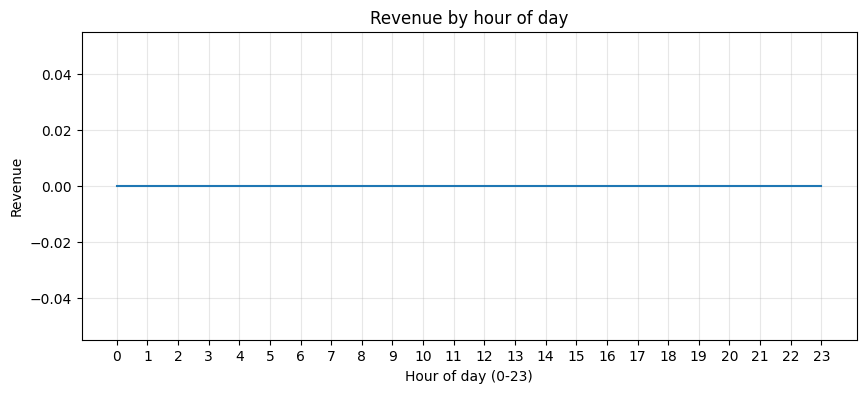

In [ ]:
# Question 6: What are the peak hours of sales?

# Create hour column from order_date
full['order_hour'] = full['order_date'].dt.hour
sales_by_hour = full.groupby('order_hour')['line_total'].sum().reset_index().sort_values('line_total', ascending=False)
display(sales_by_hour.head(10))

top_hours = sales_by_hour.head(5)
print("Top 5 revenue hours (hour of day 0-23):")
display(top_hours)

# Plot sales by hour
plt.figure(figsize=(10,4))
plt.plot(full.groupby('order_hour')['line_total'].sum().reindex(range(24), fill_value=0))
plt.xticks(range(24))
plt.xlabel("Hour of day (0-23)")
plt.ylabel("Revenue")
plt.title("Revenue by hour of day")
plt.grid(alpha=0.3)
plt.show()


,order_dayname,line_total
0,Monday,0.0
1,Tuesday,0.0
2,Wednesday,0.0
3,Thursday,0.0
4,Friday,0.0
5,Saturday,0.0
6,Sunday,0.0


Day with the most sales: Monday with revenue $0.00


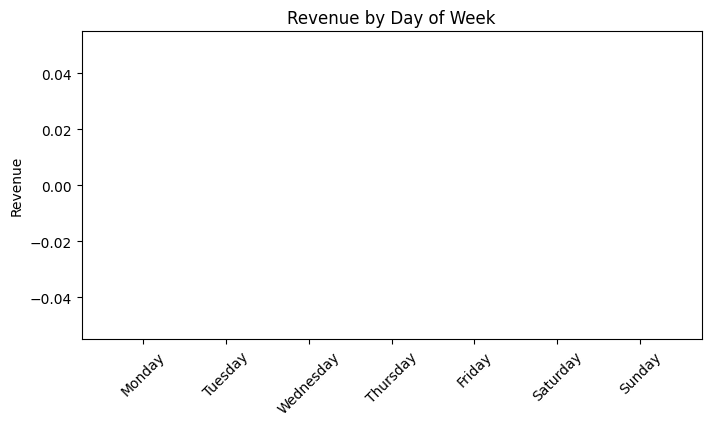

In [ ]:
# Question 7: Find the total sales made on each day of the week.
full['order_dayname'] = full['order_date'].dt.day_name()
sales_by_day = full.groupby('order_dayname')['line_total'].sum().reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
]).fillna(0).reset_index()
display(sales_by_day)

best_day = sales_by_day.sort_values('line_total', ascending=False).iloc[0]
print(f"Day with the most sales: {best_day['order_dayname']} with revenue ${best_day['line_total']:.2f}")

# Plot
plt.figure(figsize=(8,4))
plt.bar(sales_by_day['order_dayname'], sales_by_day['line_total'])
plt.xticks(rotation=45)
plt.ylabel("Revenue")
plt.title("Revenue by Day of Week")
plt.show()


Top 5 pizzas by quantity sold:


,pizza_type_name,quantity,pct_of_total_qty,line_total
3,The Big Meat Pizza,1914,3.86,0.0
80,The Thai Chicken Pizza,1410,2.84,0.0
20,The Five Cheese Pizza,1409,2.84,0.0
21,The Four Cheese Pizza,1316,2.65,0.0
18,The Classic Deluxe Pizza,1181,2.38,0.0


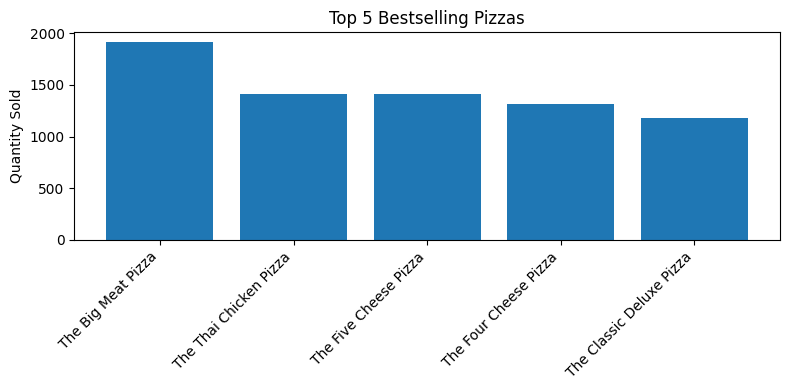

In [ ]:
#   Question 8) Find the best five delling pizzas.

Top 5 bestselling pizzas (by quantity)
import matplotlib.pyplot as plt

# group and sum (note the double brackets for multiple columns)
pizza_sales = full.groupby(['pizza_id','pizza_type_name'])[['quantity','line_total']].sum().reset_index()

# sort and pick top5
pizza_sales = pizza_sales.sort_values('quantity', ascending=False)
top5 = pizza_sales.head(5).copy()

# add percent of total quantity for context
total_qty = pizza_sales['quantity'].sum()
top5['pct_of_total_qty'] = (top5['quantity'] / total_qty * 100).round(2)

# display
print("Top 5 pizzas by quantity sold:")
display(top5[['pizza_type_name','quantity','pct_of_total_qty','line_total']])

# plot
plt.figure(figsize=(8,4))
plt.bar(top5['pizza_type_name'].astype(str), top5['quantity'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Quantity Sold")
plt.title("Top 5 Bestselling Pizzas")
plt.tight_layout()
plt.show()


,order_month,line_total
0,2015-01-01,0.0
1,2015-02-01,0.0
2,2015-03-01,0.0
3,2015-04-01,0.0
4,2015-05-01,0.0
5,2015-06-01,0.0
6,2015-07-01,0.0
7,2015-08-01,0.0
8,2015-09-01,0.0
9,2015-10-01,0.0


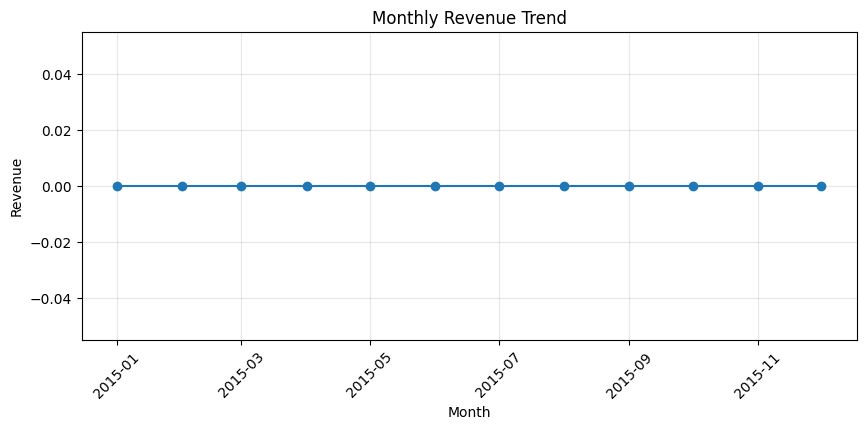

In [ ]:
# Question 9: Find the sales made in each month. Any trend noticeable?
full['order_month'] = full['order_date'].dt.to_period('M').dt.to_timestamp()
sales_by_month = full.groupby('order_month')['line_total'].sum().reset_index().sort_values('order_month')
display(sales_by_month)

# Plot
plt.figure(figsize=(10,4))
plt.plot(sales_by_month['order_month'], sales_by_month['line_total'], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Monthly Revenue Trend")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Question 10: Are there pizza types that are not doing well on the menu?
# Approach: find pizzas with zero sales and pizza types with low total revenue/quantity
# 10a: pizzas on menu with zero sales
sold_pizza_ids = full['pizza_id'].unique()
pizzas['sold_qty'] = pizzas['pizza_id'].map(lambda x: full.loc[full['pizza_id']==x, 'quantity'].sum() if x in sold_pizza_ids else 0)
no_sales_pizzas = pizzas[pizzas['sold_qty'] == 0]
print("Pizzas on menu with zero sales (not ordered at all):")
display(no_sales_pizzas[['pizza_id','menu_price']])

# 10b: pizza types by revenue and quantity
type_sales = full.groupby('pizza_type_name').agg(total_qty=('quantity','sum'), total_rev=('line_total','sum')).reset_index().sort_values('total_rev')
display(type_sales)

# Flag low-performing types: bottom 20% by revenue
threshold = type_sales['total_rev'].quantile(0.2)
low_types = type_sales[type_sales['total_rev'] <= threshold]
print("Pizza types in bottom 20% by revenue:")
display(low_types)


Pizzas on menu with zero sales (not ordered at all):


KeyError: "['pizza_name'] not in index"

In [ ]:
# Question 10: Are there pizza types that are not doing well on the menu?

# Find the pizzas with zero sales and pizza types with low total revenue/quantity
# 10a: pizzas on menu with zero sales
sold_pizza_ids = full['pizza_id'].unique()
pizzas['sold_qty'] = pizzas['pizza_id'].map(lambda x: full.loc[full['pizza_id']==x, 'quantity'].sum() if x in sold_pizza_ids else 0)
no_sales_pizzas = pizzas[pizzas['sold_qty'] == 0]
print("Pizzas on menu with zero sales (not ordered at all):")
display(no_sales_pizzas[['pizza_id','menu_price']])

# 10b: pizza types by revenue and quantity
type_sales = full.groupby('pizza_type_name').agg(total_qty=('quantity','sum'), total_rev=('line_total','sum')).reset_index().sort_values('total_rev')
display(type_sales)

# Flag low-performing types: bottom 20% by revenue
threshold = type_sales['total_rev'].quantile(0.2)
low_types = type_sales[type_sales['total_rev'] <= threshold]
print("Pizza types in bottom 20% by revenue:")
display(low_types)


Pizzas on menu with zero sales (not ordered at all):


,pizza_id,menu_price
19,big_meat_m,16.00
20,big_meat_l,20.50
69,five_cheese_s,12.50
70,five_cheese_m,15.50
72,four_cheese_s,11.75


,pizza_type_name,total_qty,total_rev
0,The Barbecue Chicken Pizza,2432,0.0
1,The Big Meat Pizza,1914,0.0
2,The Brie Carre Pizza,490,0.0
3,The Calabrese Pizza,937,0.0
4,The California Chicken Pizza,2370,0.0
5,The Chicken Alfredo Pizza,987,0.0
6,The Chicken Pesto Pizza,973,0.0
7,The Classic Deluxe Pizza,2453,0.0
8,The Five Cheese Pizza,1409,0.0
9,The Four Cheese Pizza,1902,0.0


Pizza types in bottom 20% by revenue:


,pizza_type_name,total_qty,total_rev
0,The Barbecue Chicken Pizza,2432,0.0
1,The Big Meat Pizza,1914,0.0
2,The Brie Carre Pizza,490,0.0
3,The Calabrese Pizza,937,0.0
4,The California Chicken Pizza,2370,0.0
5,The Chicken Alfredo Pizza,987,0.0
6,The Chicken Pesto Pizza,973,0.0
7,The Classic Deluxe Pizza,2453,0.0
8,The Five Cheese Pizza,1409,0.0
9,The Four Cheese Pizza,1902,0.0


## MORE ANALYSIS FOR FURTHER EXPLORATION

In [ ]:
#To check the best day of the week for sales!

full["order_date"] = pd.to_datetime(full["order_date"], errors="coerce")
full["weekday"] = full["order_date"].dt.day_name()

weekday_sales = full.groupby("weekday")["line_total"].sum().sort_values(ascending=False)
print(weekday_sales)


weekday
Friday       0.0
Monday       0.0
Saturday     0.0
Sunday       0.0
Thursday     0.0
Tuesday      0.0
Wednesday    0.0
Name: line_total, dtype: float64


In [ ]:
#To check the revenue per order!

order_value = full.groupby("order_id")["line_total"].sum()
print(order_value.describe())


count    21350.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: line_total, dtype: float64


In [ ]:
#To check the category level probability!

category_sales = full.groupby("pizza_type_name")["line_total"].sum().sort_values(ascending=False)
print(category_sales)


pizza_type_name
The Barbecue Chicken Pizza                    0.0
The Big Meat Pizza                            0.0
The Brie Carre Pizza                          0.0
The Calabrese Pizza                           0.0
The California Chicken Pizza                  0.0
The Chicken Alfredo Pizza                     0.0
The Chicken Pesto Pizza                       0.0
The Classic Deluxe Pizza                      0.0
The Five Cheese Pizza                         0.0
The Four Cheese Pizza                         0.0
The Greek Pizza                               0.0
The Green Garden Pizza                        0.0
The Hawaiian Pizza                            0.0
The Italian Capocollo Pizza                   0.0
The Italian Supreme Pizza                     0.0
The Italian Vegetables Pizza                  0.0
The Mediterranean Pizza                       0.0
The Mexicana Pizza                            0.0
The Napolitana Pizza                          0.0
The Pepper Salami Pizza           

In [ ]:
#To check sales trend over time!

monthly_sales = full.groupby(full["order_date"].dt.to_period("M"))["line_total"].sum()
print(monthly_sales)


order_date
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
2015-06    0.0
2015-07    0.0
2015-08    0.0
2015-09    0.0
2015-10    0.0
2015-11    0.0
2015-12    0.0
Freq: M, Name: line_total, dtype: float64


In [ ]:
#To check the best selling pizza size!

size_sales = full.groupby("size")["quantity"].sum().sort_values(ascending=False)
print(size_sales)


size
L      18956
M      15635
S      14403
XL       552
XXL       28
Name: quantity, dtype: int64


In [ ]:
#To check the price elasticity!

avg_price_qty = full.groupby("pizza_type_name").agg(
    avg_price=("line_total","mean"),
    total_qty=("quantity","sum")
).sort_values("avg_price")
print(avg_price_qty.head(10))


                              avg_price  total_qty
pizza_type_name                                   
The Barbecue Chicken Pizza          0.0       2432
The Big Meat Pizza                  0.0       1914
The Brie Carre Pizza                0.0        490
The Calabrese Pizza                 0.0        937
The California Chicken Pizza        0.0       2370
The Chicken Alfredo Pizza           0.0        987
The Chicken Pesto Pizza             0.0        973
The Classic Deluxe Pizza            0.0       2453
The Five Cheese Pizza               0.0       1409
The Four Cheese Pizza               0.0       1902


In [ ]:
#To check the ingredient popularity (from the pizza_types file)

from collections import Counter
ingredients = pizza_types["ingredients"].str.split(",").sum()
ingredient_counts = Counter([i.strip() for i in ingredients])
print(ingredient_counts.most_common(10))


[('Garlic', 20), ('Tomatoes', 18), ('Red Onions', 13), ('Red Peppers', 10), ('Spinach', 8), ('Mushrooms', 7), ('Pepperoni', 6), ('Mozzarella Cheese', 6), ('Chicken', 5), ('Artichokes', 5)]
